<a href="https://colab.research.google.com/github/vimesh630/ML_CW/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Mount Google Drive

In [20]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Preprocess Data

In [21]:
# Load preprocessed data
train_data_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/X_train.csv'
test_data_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/X_test.csv'

y_train_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/y_train.csv'
y_test_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/y_test.csv'

# Load data
X_train = pd.read_csv(train_data_path).values
X_test = pd.read_csv(test_data_path).values
y_train = pd.read_csv(y_train_path).values.ravel()
y_test = pd.read_csv(y_test_path).values.ravel()

Perform Hyperparameter Tuning with Grid Search

In [22]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [150, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and accuracy from GridSearchCV
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy from Grid Search: {best_accuracy:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy from Grid Search: 0.9549


Train the Random Forest Model with Best Parameters

In [23]:
# Train Random Forest with best parameters
rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)

Evaluate the Model

In [24]:
# Predict on test data
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate accuracy metrics
train_accuracy = rf_model.score(X_train, y_train)  # Training accuracy
test_accuracy = accuracy_score(y_test, y_pred)     # Test accuracy
roc_auc = roc_auc_score(y_test, y_pred_proba)      # ROC-AUC score

# Print accuracy values
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Accuracy: 0.9953
Test Accuracy: 0.9597
ROC-AUC Score: 0.9949

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8015
           1       0.94      0.99      0.96      8072

    accuracy                           0.96     16087
   macro avg       0.96      0.96      0.96     16087
weighted avg       0.96      0.96      0.96     16087



Save Results to JSON

In [25]:
# Save Random Forest results as JSON
rf_results = {
    "training_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    "roc_auc": roc_auc,
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "fpr": roc_curve(y_test, y_pred_proba)[0].tolist(),  # False positive rate
    "tpr": roc_curve(y_test, y_pred_proba)[1].tolist()   # True positive rate
}

output_path = '/content/drive/My Drive/ML Coursework/Model_Results/rf_results.json'
with open(output_path, 'w') as f:
    json.dump(rf_results, f)

print(f"Random Forest results saved to: {output_path}")

Random Forest results saved to: /content/drive/My Drive/ML Coursework/Model_Results/rf_results.json


# Visualiations

Confusion Matrix

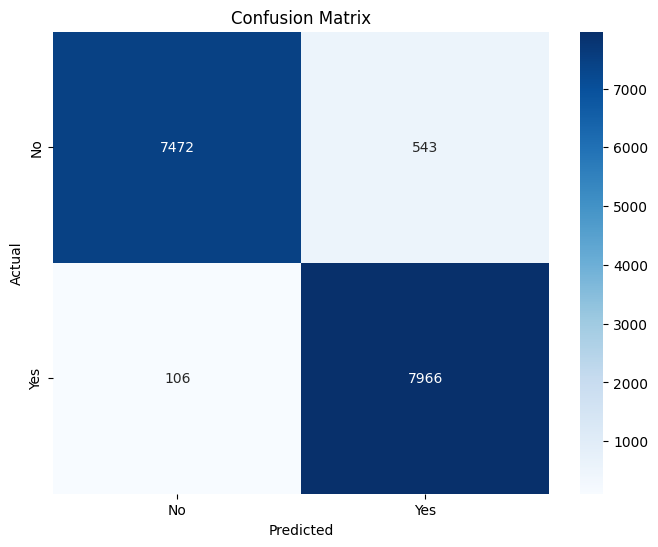

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

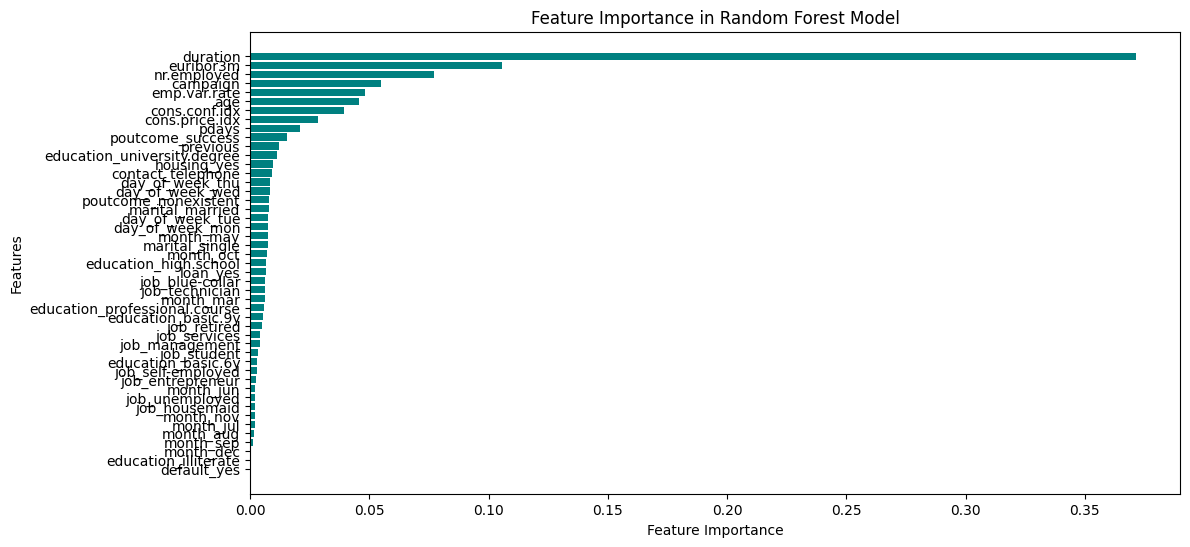

In [27]:
feature_importances = rf_model.feature_importances_
feature_names = pd.read_csv(train_data_path).columns
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
plt.barh(importance_df["Feature"], importance_df["Importance"], color='teal')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

ROC Curve

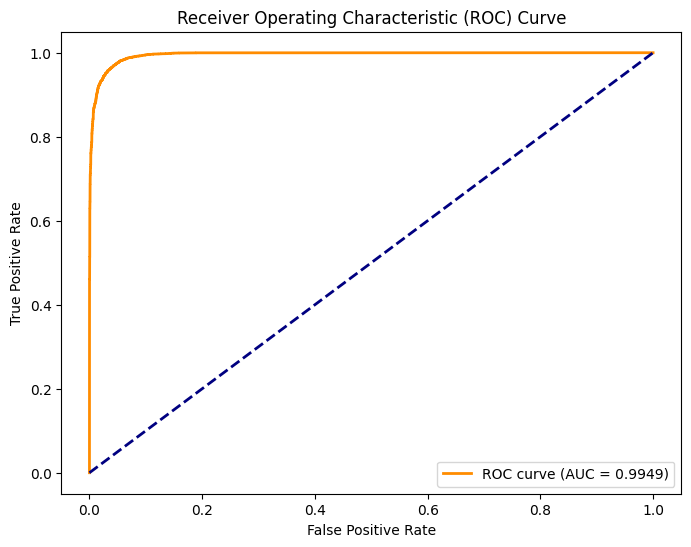

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Predictions for Sample Clients

In [29]:
# Predict probabilities and classes for sample clients
sample_clients = X_test[:10]
predicted_probabilities = rf_model.predict_proba(sample_clients)[:, 1]  # Probabilities for class "1" (Yes)
predicted_classes = rf_model.predict(sample_clients)  # Binary predictions

# Print the results
print("Predicted Probabilities for 'Yes':\n", predicted_probabilities)
print("Predicted Classes (0 = No, 1 = Yes):\n", predicted_classes)

Predicted Probabilities for 'Yes':
 [0.00411288 0.20212321 0.94083524 0.96529515 0.01494575 0.79612915
 0.85105863 0.90935675 0.01754241 0.13341245]
Predicted Classes (0 = No, 1 = Yes):
 [0 0 1 1 0 1 1 1 0 0]
